In [ ]:
import csv
import cv2 as cv
import numpy
from keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.initializers import glorot_uniform
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
X_train = []
Y_train = []

with open('/content/drive/MyDrive/images_color.csv', 'r') as f:
  reader = csv.reader(f)
  for row in reader:
    if row[0]!='':
      label = row[0]
      image = numpy.array([int(a) for a in row[1:]], dtype='uint8')
      image = image.reshape((32, 32, 3))
      image = cv.resize(image,(64, 64))
      X_train.append(image)
      Y_train.append(label)

X_train, _, Y_train, _ = train_test_split(X_train, Y_train, train_size=39208)
X_train = numpy.array(X_train)
Y_train = numpy.array(Y_train)

Y_train = to_categorical(Y_train)
print(X_train.shape)
print(Y_train.shape)


(39208, 64, 64, 3)
(39208, 43)


In [ ]:
X_test = []
Y_test = []

with open('/content/drive/MyDrive/test_set_in_csv.csv', 'r') as f:
  reader = csv.reader(f)
  header = next(reader)
  for row in reader:
    if len(row)!=0:
      label = row[0]
      image = numpy.array([int(a) for a in row[1:]], dtype='uint8')
      image = image.reshape((32, 32, 3))
      image = cv.resize(image, (64, 64))
      X_test.append(image)
      Y_test.append(label)

X_test = numpy.array(X_test)
Y_test = numpy.array(Y_test)

Y_test = to_categorical(Y_test)
print(X_test.shape)
print(Y_test.shape)

(12629, 64, 64, 3)
(12629, 43)


In [ ]:
def tsr_model(input_shape=(64, 64, 3)):
  model = Sequential()
  model.add(Input(input_shape))
  model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv1'))
  model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv2'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv3'))
  model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv4'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv5'))
  model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv6'))
  model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv7'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv8'))
  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv9'))
  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv10'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv11'))
  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv12'))
  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', kernel_regularizer=l2(0.001), name='conv13'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(0.001), name='fc1'))
  model.add(Dense(43, activation='softmax', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(0.001), name='fc2'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = tsr_model(input_shape=(64, 64, 3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 128)       73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv5 (Conv2D)               (None, 16, 16, 256)      

In [ ]:
aug = ImageDataGenerator(rotation_range=10, zoom_range=0.05, 
                         width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.15, horizontal_flip=False, 
                         fill_mode='nearest')
model.fit(X_train, Y_train, epochs=15, batch_size=128, validation_data=(X_test, Y_test))

Epoch 1/15
307/307 [==============================] - 89s 286ms/step - loss: 6.7061 - accuracy: 0.0635 - val_loss: 4.2795 - val_accuracy: 0.0960
Epoch 2/15
307/307 [==============================] - 88s 287ms/step - loss: 4.1647 - accuracy: 0.1048 - val_loss: 3.2769 - val_accuracy: 0.2673
Epoch 3/15
307/307 [==============================] - 88s 288ms/step - loss: 2.6006 - accuracy: 0.4354 - val_loss: 1.6167 - val_accuracy: 0.7517
Epoch 4/15
307/307 [==============================] - 88s 288ms/step - loss: 1.1977 - accuracy: 0.8656 - val_loss: 1.1552 - val_accuracy: 0.8876
Epoch 5/15
307/307 [==============================] - 88s 288ms/step - loss: 0.8229 - accuracy: 0.9524 - val_loss: 0.9560 - val_accuracy: 0.9038
Epoch 6/15
307/307 [==============================] - 88s 287ms/step - loss: 0.6492 - accuracy: 0.9733 - val_loss: 0.9268 - val_accuracy: 0.9078
Epoch 7/15
307/307 [==============================] - 88s 287ms/step - loss: 0.6346 - accuracy: 0.9643 - val_loss: 0.7894 - val_ac

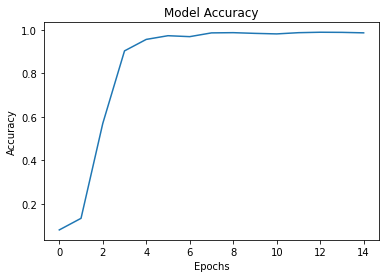

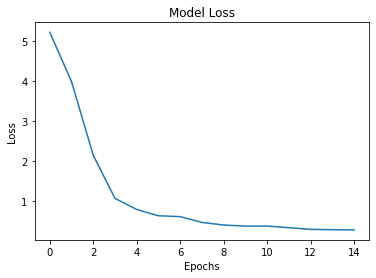

In [ ]:
from matplotlib import pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(model.history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/tsr_model_v4.h5')

In [ ]:
from keras.models import load_model
import cv2 as cv
import numpy
import csv
from keras.utils import to_categorical
model = load_model('/content/drive/MyDrive/tsr_model_v4.h5')

In [ ]:
prediction = model.evaluate(X_test, Y_test)
print('loss : {}'.format(prediction[0]))
print('accuracy: {}'.format(prediction[1]))

395/395 [==============================] - 12s 31ms/step - loss: 0.4615 - accuracy: 0.9553
loss : 0.46151697635650635
accuracy: 0.9552617073059082


In [ ]:
from sklearn.metrics import classification_report
import numpy

y_pred = model.predict(X_test)
y_pred = numpy.argmax(y_pred, axis=1)
Y_test = numpy.argmax(Y_test, axis=1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        59
           1       0.98      0.98      0.98       720
           2       0.98      0.99      0.99       750
           3       0.98      0.94      0.96       450
           4       0.95      0.98      0.97       660
           5       0.94      0.97      0.95       630
           6       1.00      0.85      0.92       150
           7       1.00      0.98      0.99       450
           8       0.96      0.95      0.95       450
           9       0.99      0.98      0.98       480
          10       0.97      0.97      0.97       660
          11       0.97      0.99      0.98       420
          12       0.97      0.98      0.97       690
          13       0.98      0.99      0.98       720
          14       0.96      1.00      0.98       270
          15       1.00      0.94      0.97       210
          16       0.98      0.99      0.99       150
          17       0.99    